In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data_from_npy_files(data_dir):
    X, y = [], []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(data_dir, file_name)
            data = np.load(file_path, allow_pickle=True).item()  
            
            frames = data['frames']
            label = data['label']
            
            X.append(frames)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

train_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/train'
test_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/test'

X_train, y_train = load_data_from_npy_files(train_data_dir)
X_test, y_test = load_data_from_npy_files(test_data_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (1431, 32, 64, 64, 3), Labels shape: (1431,)
Validation data shape: (358, 32, 64, 64, 3), Labels shape: (358,)
Testing data shape: (306, 32, 64, 64, 3), Labels shape: (306,)


In [2]:
import numpy as np
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling3D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Concatenate

def build_c3d_feature_extractor(input_shape=(32, 64, 64, 3)):
    inputs = Input(shape=input_shape)

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    model = Model(inputs, x, name="C3D_Feature_Extractor")

    return model

def extract_features(video_segments, c3d_model):
    features = []
    for segment in video_segments:
        segment = np.expand_dims(segment, axis=0)
        feature_vector = c3d_model.predict(segment)
        features.append(feature_vector.flatten())
    return np.array(features)

c3d_feature_extractor = build_c3d_feature_extractor()
c3d_feature_extractor.summary()

Model: "C3D_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 32, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 8, 8, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 4, 4, 512)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,651,008 (17.74 MB)

 Trainable params: 4,651,008 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

c3d_feature_extractor = build_c3d_feature_extractor()
c3d_feature_extractor.summary()

X_train_features = extract_features(X_train, c3d_feature_extractor)
X_val_features = extract_features(X_val, c3d_feature_extractor)
X_test_features = extract_features(X_test, c3d_feature_extractor)

Model: "C3D_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 32, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 32, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 16, 8, 8, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 16, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 8, 4, 4, 512)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,651,008 (17.74 MB)

 Trainable params: 4,651,008 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1731893130.354674      97 service.cc:145] XLA service 0x79f604004890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731893130.354784      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


I0000 00:00:1731893131.628334      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [4]:
import tensorflow as tf

def ranking_loss(y_true, y_pred, margin=1.0):
    squared_diff = tf.square(y_true - y_pred)
    
    loss = y_true * squared_diff + (1 - y_true) * tf.maximum(0.0, margin - squared_diff)
    
    return tf.reduce_mean(loss)
def temporal_smoothness_loss(y_true, y_pred):
    temporal_diff = tf.abs(y_pred[1:] - y_pred[:-1])

    loss = tf.reduce_mean(temporal_diff)

    return loss
    
def combined_loss(y_true, y_pred, margin=1.0, smoothness_weight=0.05, ranking_weight=1.0):

    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    temporal_loss = temporal_smoothness_loss(y_true, y_pred)

    ranking_loss_val = ranking_loss(y_true, y_pred, margin)

    total_loss = bce_loss + (ranking_weight * ranking_loss_val) - (smoothness_weight * temporal_loss)

    return total_loss

In [5]:
fc_classifier = Sequential([
Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
Dense(256, activation='relu'),
Dense(1, activation='sigmoid')  
])

fc_classifier.compile(
    optimizer='adam', 
    loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

checkpoint = ModelCheckpoint("c3d_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

fc_history = fc_classifier.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_val_features, y_val), callbacks=[checkpoint, early_stop])

fc_classifier.save('c3d_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4986 - loss: 1.1639
Epoch 1: val_loss improved from inf to 0.71157, saving model to c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4989 - loss: 1.1579 - val_accuracy: 0.4693 - val_loss: 0.7116
Epoch 2/20
39/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5438 - loss: 0.6880
Epoch 2: val_loss improved from 0.71157 to 0.64165, saving model to c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5482 - loss: 0.6862 - val_accuracy: 0.6536 - val_loss: 0.6417
Epoch 3/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6103 - loss: 0.6593
Epoch 3: val_loss improved from 0.64165 to 0.60609, saving model to c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6103 - loss: 0.6592 - val_accuracy: 0.7179 - val_loss: 0.6061
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5780 - loss: 0.6922
Epoch 4: val_loss did not improve from 0.60609
45/45 ━━━━━━━━━━━━━━

In [6]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def extract_segments_from_video(video_path, segment_length=32, frame_size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
        
    video_segments = []
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, frame_size)
        
        frame = frame / 255.0
        
        frames.append(frame)
        
        if len(frames) == segment_length:
            video_segments.append(np.array(frames))  
            frames = []  

    if len(frames) > 0:
        
        padding_frames = segment_length - len(frames)
        
        last_frame = frames[-1]
        for _ in range(padding_frames):
            frames.append(last_frame)
        
        video_segments.append(np.array(frames))
    
    cap.release()
    
    video_segments = np.array(video_segments)
    print(f"Shape of video segments: {video_segments.shape}")  
    
    return video_segments
    
def predict_with_model(X_features, s):
    
    predictions = s.predict(X_features)
    return predictions

def create_video_from_segments(filtered_segments, output_path, fps=30, frame_size=(64, 64)):
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    
    for segment in filtered_segments:
        for frame in segment:
            
            frame_uint8 = (frame * 255).astype(np.uint8)
            out.write(cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR))  
    
    out.release()  
    print(f"Filtered video saved to {output_path}")

In [7]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/kaggle/working/c3d_model.h5',custom_objects={'combined_loss':combined_loss})

In [8]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,686,531 (128.50 MB)

 Trainable params: 33,686,529 (128.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [9]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

video_segments = extract_segments_from_video('/kaggle/input/arson-video/Arson046_x264.mp4')

X_features = extract_features(video_segments, c3d_feature_extractor)

predictions = predict_with_model(X_features, loaded_model)

threshold = 0.8
filtered_indices = np.where(predictions < threshold)[0]  
filtered_segments = video_segments[filtered_indices]  

print(f"Number of filtered segments: {len(filtered_segments)}")

create_video_from_segments(filtered_segments, output_path='summary_video.mp4', fps=30, frame_size=(64, 64))


Shape of video segments: (65, 32, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━

In [10]:
print(len(predictions))
print(len(video_segments))

65
65


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


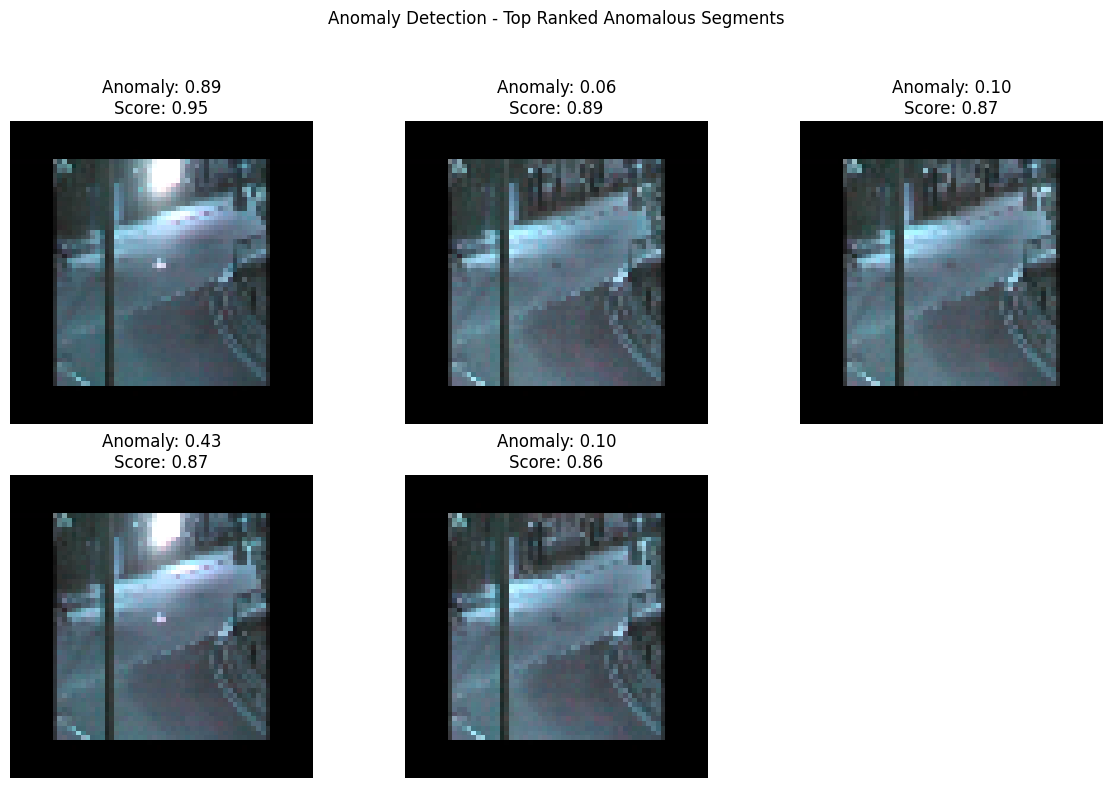

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def compute_segment_score(memorability, entropy, temporal_dynamics, weights=(0.5, 0.3, 0.2)):
    return (weights[0] * memorability) + (weights[1] * entropy) + (weights[2] * temporal_dynamics)

memorability_scores = np.random.rand(len(X_features))  
entropy_scores = np.random.rand(len(X_features))      
temporal_dynamics_scores = np.random.rand(len(X_features)) 

segment_scores = [
    compute_segment_score(m, e, t)
    for m, e, t in zip(memorability_scores, entropy_scores, temporal_dynamics_scores)
]

predictions = fc_classifier.predict(X_features)
anomaly_scores = predictions[:, 0]  

combined_scores = [a * s for a, s in zip(anomaly_scores, segment_scores)]
top_segments = np.argsort(combined_scores)[:5]  

num_top_segments = len(top_segments)
cols = min(num_top_segments, 3) 
rows = (num_top_segments + cols - 1) // cols 

plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(top_segments):
    segment = video_segments[idx]           
    first_image = segment[0]         
         
    prediction = anomaly_scores[idx] 
    score = combined_scores[idx]     

    plt.subplot(rows, cols, i + 1)
    plt.imshow(first_image)
    plt.title(f"Anomaly: {1-prediction:.2f}\nScore: {1-score:.2f}")
    plt.axis('off')

plt.suptitle("Anomaly Detection - Top Ranked Anomalous Segments")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


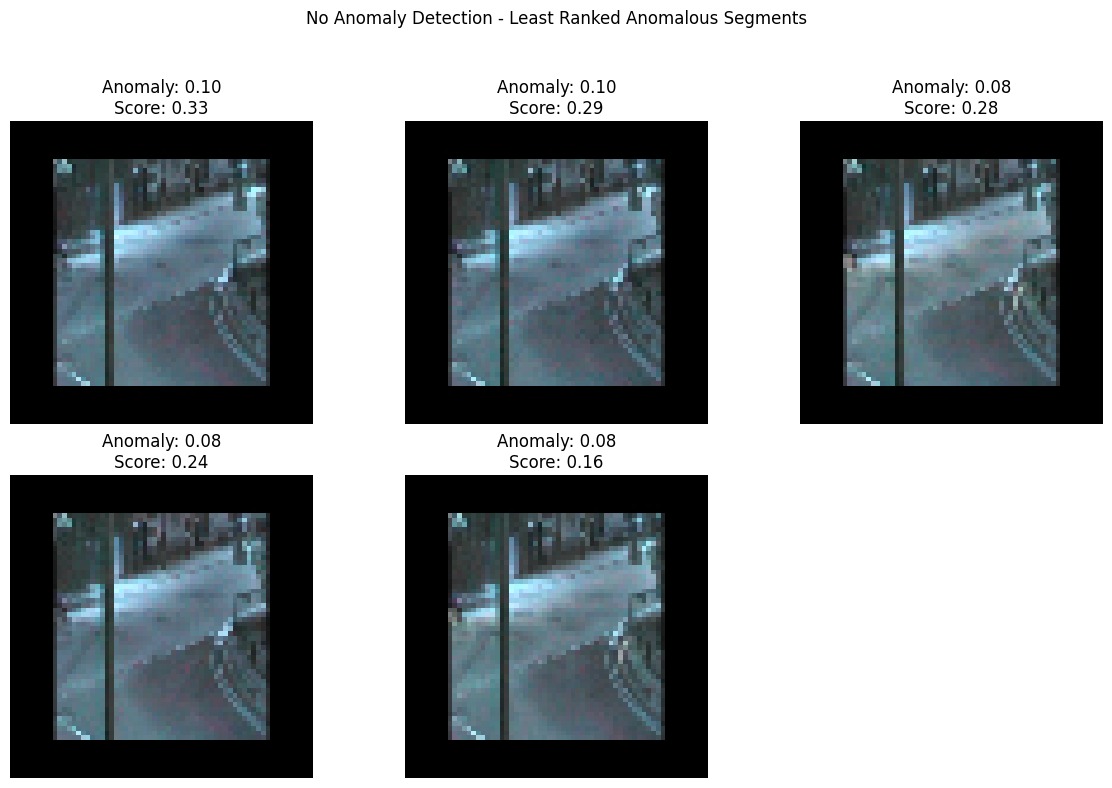

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def compute_segment_score(memorability, entropy, temporal_dynamics, weights=(0.5, 0.3, 0.2)):
    return (weights[0] * memorability) + (weights[1] * entropy) + (weights[2] * temporal_dynamics)

memorability_scores = np.random.rand(len(X_features))  
entropy_scores = np.random.rand(len(X_features))      
temporal_dynamics_scores = np.random.rand(len(X_features)) 

segment_scores = [
    compute_segment_score(m, e, t)
    for m, e, t in zip(memorability_scores, entropy_scores, temporal_dynamics_scores)
]

predictions = fc_classifier.predict(X_features)
anomaly_scores = predictions[:, 0]  

combined_scores = [a * s for a, s in zip(anomaly_scores, segment_scores)]
top_segments = np.argsort(combined_scores)[-5:]  


num_top_segments = len(top_segments)
cols = min(num_top_segments, 3) 
rows = (num_top_segments + cols - 1) // cols 

plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(top_segments):
    segment = video_segments[idx]           
    first_image = segment[0]         
         
    prediction = anomaly_scores[idx] 
    score = combined_scores[idx]     
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(first_image)
    plt.title(f"Anomaly: {1-prediction:.2f}\nScore: {1-score:.2f}")
    plt.axis('off')

plt.suptitle("No Anomaly Detection - Least Ranked Anomalous Segments")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()